# How to Clean up a Dataset

![Baby Bunny](img/kit.jpeg)

## Load Libraries

In [6]:
%matplotlib inline
#generic imports
import csv
import notebook as nb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import json
import sys
import inspect
import math
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.utils import shuffle

import random

dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You have some example documents with classifications and you want to increase the accuracy of predictions you make with this dataset. This is a workshop to find issues in a dataset with python. 

We use a bunny farm chatbot. But sentiment analysis, news, email classification or any supervised learning dataset will have similar issues.

## Bashful Bunnies

A pet rabbit seller on facebook wants to answer common customer questions while they are offline. They give you previous questions they have been asked. And you help them label these by Topic_Verb. This is a whole other talk.

Now you want to quickly go through these labels to find mistakes. Usually 500 questions in 20-50 intents. 

# Tasks
<input type="checkbox"> Load Libraries
<input type="checkbox"> Load Data
<input type="checkbox"> Language specific stuff (spelling, accents, segment words in Chinese etc)
<input type="checkbox"> Run KFold test
<input type="checkbox"> Save Data to show improvements
<input type="checkbox"> Graph questions, Intents and Accuracy
<input type="checkbox"> Find Duplicates
<input type="checkbox"> Find Wrongly labeled
<input type="checkbox"> Find Double Categories
<input type="checkbox"> Find Nonsense
<input type="checkbox"> Find Bad intents
<input type="checkbox"> Look at confusion Matrix
<input type="checkbox"> Label new data 


## Load Data

First off load the data. The file needs to be this name, type and in he local directory. And in the format Question, Intent with a header

In [116]:
filePath = r'bunny.csv'
df = pd.read_csv(filePath,header=0,encoding='utf-8')
df.head()

,Question,Intent
0,Are the baby rabbits certified?,RABBIT_CERTIFICATION
1,What cert does the kit have?,RABBIT_CERTIFICATION
2,Does the rabbit have a certificate? And what f...,RABBIT_CERTIFICATION
3,Is the kit certified by a vet?,RABBIT_CERTIFICATION
4,Has the kit been cleared by a vet?,RABBIT_CERTIFICATION


Ground Truth is utterence (question), intent

  - Real questions from real users
  - Topic_Verb the utterences
 
 10 topics, 50 intents, 2000 Questions but this process here with 500.

# Start Analysis

## Make Kfolds

Make a classifier and get it to classify every quesstion in the training data. 

What it gets wrong we look at to see if our original classificationw as wrong.

In [117]:
#Make five folds
#shuffle the data
df = shuffle(df, random_state=0)
df = df.dropna()
numFolds=5
size=math.trunc(len(df)/numFolds)
#MAke the flds 5 folds
Fold1=df[:size]
Fold2=df[size:(size*2)]
Fold3=df[(size*2):(size*3)]
Fold4=df[(size*3):(size*4)]
Fold5=df[(size*4):]

### now we have folds define a classifier

In [118]:


text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),# tokenizer=LemmaTokenizer() ,ngram_range=(1, 2)  ,stop_words=stopWords ngram_range=(1, 1)
                    ('clf',  SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-3, tol=0.001, max_iter=1000, random_state=42)),#n_iter=20 'hinge'
                    #('clf',  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
                    ]) 


In [119]:
#This is what makes train smaller
train = pd.concat([Fold2, Fold3, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)


df1 = pd.DataFrame(columns=['Question', 'GTIntent', 'Prediction 1','Conf 1','Pred2','conf2','match'])

total=0


def runFold(test):
    i=0
    global total,df1

    for row in test.iterrows():
        row2=[test.iloc[i,0]]
        #row2=[row]
        predicted=text_clf.predict(row2)
        values= text_clf.predict_proba(row2)
        best_n = np.argsort(values, axis=1)[:,-3:]
    
        if test.iloc[i,1]==predicted[0]:
                match=1
                total=total+1
        else:
                match=0
            

        df1 = df1.append({'Question' : row2[0] , 'GTIntent' : test.iloc[i,1],'Prediction 1':text_clf.classes_[best_n.item(2)],'Conf 1':math.trunc(values[0][best_n.item(2)]*100),'Pred2':text_clf.classes_[best_n.item(1)],'conf2':math.trunc(values[0][best_n.item(1)]*100),'match':match} , ignore_index=True)#,'':,'':,'':,'':,'':


        i=i+1

        
train = pd.concat([Fold2, Fold3, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold1)
train = pd.concat([Fold1, Fold3, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold2)
train = pd.concat([Fold1, Fold2, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold3)
train = pd.concat([Fold1, Fold2, Fold3,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold4)
train = pd.concat([Fold1, Fold2, Fold3,Fold4]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold5)


print("accuracy is "+str(total/(len(Fold1)*5)))
df1.to_excel('checkThese.xlsx', encoding='utf-8', index=False)#



accuracy is 0.7130434782608696


In [120]:
## save data in a csv 
## Date, Accuracy, intent numbers, question numbers
import datetime as dt
now=dt.datetime.today().strftime("%m/%d/%Y")

with open("result_statistics.csv", "a") as myfile:
    myfile.write(now+","+str(df['Intent'].nunique())+","+str(len(df))+","+str(math.trunc((total/(len(Fold1)*5)*100)))+"\n")    

![rabbit eating](img/coco2.jpg)

## Find Errors

Three kinds of errors

Duplicates

Confident and wrong

Second Confidence High

Low confidence nonesense

In [121]:
df1.tail()

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
111,Ba mhaith liom coinin. Ach nil aon airgead agam,PURCHASE_RABBIT,RABBIT_HEALTH,31,BREEDER_REFERENCES,19,0
112,has the kit had to go see a vet?,RABBIT_HEALTH,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,1
113,Did the rabbit have to visit a vet?,RABBIT_HEALTH,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,1
114,Do you verify that the kit does not have fleas?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
115,Can you guarantee the rabbit doesn't have worms?,RABBIT_HEALTH,RABBIT_HEALTH,50,BREEDER_GUARANTEE,50,0


In [122]:
dupes = pd.DataFrame()
dupes=df[df.duplicated('Question', keep=False)]
dupes = dupes.sort_values('Question',ascending=False)

htmld = dupes.to_html()

dupes

,Question,Intent
111,Any rabbits to sell?,PURCHASE_RABBIT
113,Any rabbits to sell?,PURCHASE_RABBIT


![dog](img/dog.jpg) 

In [113]:
#Find high confidence wrong
highWrong = df1[(df1['Conf 1'] > 95) & (df1['match'] ==0)]
highWrong=highWrong.sort_values(by=['Conf 1'],ascending=False)

htmlhw = highWrong.to_html()

highWrong    

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
3,What happens if the rabbit was not well?,RABBIT_HEALTH,PURCHASE_RABBIT,100,RABBIT_SOCIALISATION,0,0
5,Do you have a list of other people who bought ...,BREEDER_REFERENCES,RABBIT_SOCIALISATION,100,RABBIT_PARENTS,0,0
30,What shots has the rabbit gotten?,RABBIT_HEALTH,PURCHASE_RABBIT,100,RABBIT_SOCIALISATION,0,0
34,Do rabbits need a health cert,RABBIT_CERTIFICATION,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,0
35,Has the rabbit ever been unhealthy?,RABBIT_HEALTH,PURCHASE_RABBIT,100,RABBIT_SOCIALISATION,0,0
54,Has the kit been cleared by a vet?,RABBIT_CERTIFICATION,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,0
90,Would it be possible to get other buyers detai...,BREEDER_REFERENCES,RABBIT_PARENTS,100,RABBIT_SOCIALISATION,0,0
92,Do rabbits get health innoculations and vaccines?,RABBIT_HEALTH,RABBIT_CERTIFICATION,100,RABBIT_SOCIALISATION,0,0
94,I will buy the kit if you let me veterianian s...,RABBIT_HEALTH,PURCHASE_RABBIT,100,RABBIT_SOCIALISATION,0,0
113,Do you verify that the kit does not have fleas?,RABBIT_HEALTH,RABBIT_CERTIFICATION,100,RABBIT_SOCIALISATION,0,0


![two at once](img/maxresdefault.jpg) 

In [114]:
#Find intents where second intent is high confidence

doubleq = df1[df1.conf2 > 20]
doubleq=doubleq.sort_values(by=['conf2'],ascending=False)
htmldq = doubleq.to_html()

doubleq    
    

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
102,Can you tell me more about why you breed these...,BREEDER_INFORMATION,RABBIT_HEALTH,50,BREEDER_INFORMATION,50,1
36,Can I meet the parents and what rabbit food br...,RABBIT_PARENTS,RABBIT_PARENTS,50,RABBIT_FOOD,50,0
79,I would like to see the mother,RABBIT_PARENTS,RABBIT_PARENTS,50,RABBIT_FOOD,50,1
66,How does the rabbit handle strange and new peo...,RABBIT_SOCIALISATION,RABBIT_SOCIALISATION,50,RABBIT_CERTIFICATION,50,1
46,did a vet ever have to look at the bunny?,RABBIT_HEALTH,RABBIT_HEALTH,50,PURCHASE_RABBIT,50,1
55,What breed is the baby rabbits mother?,RABBIT_PARENTS,BREEDER_INFORMATION,50,RABBIT_PARENTS,49,0
32,Is the kit certified by a vet?,RABBIT_CERTIFICATION,RABBIT_CERTIFICATION,51,RABBIT_HEALTH,48,1
60,Has a vet certified the rabbit ?,RABBIT_CERTIFICATION,RABBIT_CERTIFICATION,52,RABBIT_HEALTH,47,1
11,Does the rabbit have a certificate? And what f...,RABBIT_CERTIFICATION,PURCHASE_RABBIT,54,RABBIT_FOOD,45,0
24,Do you have any kind of guarantee with the kit?,BREEDER_GUARANTEE,BREEDER_GUARANTEE,55,RABBIT_HEALTH,44,1


Why two questions at once?
  -  Customers see one task when business sees two. 'I want to cancel my card and get a new one'
  -  People complain about two things at once. 'The food is terrible and the portions are too small'
  -  Chatbot is not clear enough to ask one question at a time. This is the big reason to admit you are a chatbot
  -  Just asked two questions when they shouldnt have

![rabbit eating](img/0000049339.jpg)

In [123]:
#Find intents that are low confidence and wrong. Might be nonsense

verylow = df1[(df1['Conf 1'] < 36) & (df1['match'] ==0)]
verylow=verylow.sort_values(by=['conf2'],ascending=False)
dflc = verylow.to_html()
verylow

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
36,xxxxxxxxxxxxxx,RABBIT_PARENTS,RABBIT_HEALTH,27,PURCHASE_RABBIT,26,0
111,Ba mhaith liom coinin. Ach nil aon airgead agam,PURCHASE_RABBIT,RABBIT_HEALTH,31,BREEDER_REFERENCES,19,0
1,Can you give me any references?,BREEDER_REFERENCES,RABBIT_HEALTH,23,PURCHASE_RABBIT,18,0
7,What is your mission statement?,BREEDER_INFORMATION,RABBIT_HEALTH,23,PURCHASE_RABBIT,18,0
17,What references do you have?,BREEDER_REFERENCES,RABBIT_HEALTH,23,PURCHASE_RABBIT,18,0
4,Do rabbits get health documentation,RABBIT_CERTIFICATION,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
28,Do rabbits have parental bloodlines?,RABBIT_PARENTS,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
29,What food does the rabbit like to eat?,RABBIT_FOOD,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
34,Do rabbits need a health cert,RABBIT_CERTIFICATION,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
59,Will my rabbit need booster vacinations,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0


In [24]:
with open("all.html", 'w') as _file:
    _file.write( "<h1>Duplicates</h1>"+htmld + "\n\n<h1>Double Questions</h1>" + htmldq+ "\n\n<h1>High Confidence Wrong</h1>"+ htmlhw+ "\n\n<h1>Could be Nonsense</h1>"+ dflc)

## Find Bad Intents

![rabbit eating](img/bunny2.jpg)

In [124]:
wrong = df1[(df1['GTIntent']!=df1['Prediction 1'])]
correct = df1[(df1['GTIntent']==df1['Prediction 1'])]

wf=wrong.groupby(['GTIntent'], as_index=False).count()
crf=correct.groupby(['GTIntent'], as_index=False).count()
gf1=wf[['GTIntent','Question']]
gf1.columns = ['Intent', 'wrong']


crf1=crf[['GTIntent','Question']]
crf1.columns = ['Intent', 'right']
#crf1.head()
result = pd.merge(crf1,gf1,on='Intent',how='outer')
result=result.fillna(0)
#total questions
result['total'] = result['wrong'] + result['right']
#calculate percentage we got right
result['percent'] = (result['right']/(result['wrong'] + result['right']))*100

result=result.round(0)

In [125]:
lowAcc = result[(result.percent < 100) & (result['wrong'] >1)]
lowAcc=lowAcc.sort_values(by=['total'],ascending=False)
lowAcc

,Intent,right,wrong,total,percent
6,RABBIT_HEALTH,36,8,44,82.0
7,RABBIT_PARENTS,13,3,16,81.0
1,BREEDER_INFORMATION,9,3,12,75.0
3,PURCHASE_RABBIT,6,4,10,60.0
4,RABBIT_CERTIFICATION,4,4,8,50.0
2,BREEDER_REFERENCES,2,5,7,29.0
5,RABBIT_FOOD,2,4,6,33.0


![Low and right should be looked at](img/fixthese2.png)


## Confusion Matrix

Once you fix these basic misclassifications the next common issue is mixed up intents.

                  Actual
             Intent1 Intent2 ...     
     Intent1  
     Intets2      
     ...  
       
predicted     
       
       
       
  
 Open checkthese spreadsheet and select two intents that are mixes up
 

In [70]:
df1.head()

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
0,What are the size of the parents?,RABBIT_PARENTS,RABBIT_PARENTS,100,RABBIT_SOCIALISATION,0,1
1,Has the litter been not well?,RABBIT_HEALTH,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,1
2,What does the rabbit like to eat?,RABBIT_FOOD,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0
3,Do you have details on your breeding business?,BREEDER_INFORMATION,BREEDER_REFERENCES,100,RABBIT_SOCIALISATION,0,0
4,Do rabbits get health documentation,RABBIT_CERTIFICATION,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0


In [71]:


def get_confusion_matrix(y_true, y_pred, labels, normalize=False):
    conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels)
    if normalize:
        conf_matrix = conf_matrix.astype('float')/conf_matrix.sum(axis=1)[:, np.newaxis]
    conf = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    return conf

In [73]:
conf=df1#res[0]
cf = get_confusion_matrix(conf['GTIntent'], conf['Prediction 1'], labels=conf['GTIntent'].unique())
#df['Diag'] =pd.Series(np.diag(cf), index=[cf.index, cf.columns])
cf.tail()

conf = cf.to_csv('Confusion.csv', encoding='utf-8')

## Label Data

![rabbit eating](img/baby-bunny.jpg)

Now you have a classifier use it to classify new data. Then you can go through this labeled data and agree/disagree with it. This is much faster than labeling data yourself cold.

In [47]:
filePath = r'tolabel.csv'

label = pd.read_csv(filePath,header=0)

#label=label.drop(['Unnamed: 0'], axis=1)
label = label.dropna()        
label.head(20)


,Question
0,Do the baby rabbits get a certificate?
1,What cert do the kits have?
2,Does the rabbit have a certificate?
3,Is the kit approved by a vet?
4,Has the kit been given the OK by a vet?
5,Has a veterinarian certified the rabbit ?


In [48]:
#train = pd.concat([trainSent]) 
text_clf.fit(df.Question, df.Intent)        


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...om_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

Label all the new data. And then go through it by intent agreeing or disagreeing with the label

In [49]:
labeled = pd.DataFrame(columns=['Question', 'Prediction 1','Conf 1','Pred2','conf2'])
i=0


for row in label.iterrows():
    row2=[label.iloc[i,0]]
    predicted=text_clf.predict(row2)
    values= text_clf.predict_proba(row2)
    best_n = np.argsort(values, axis=1)[:,-3:]            
    labeled = labeled.append({'Question' : row2[0] ,'Prediction 1':text_clf.classes_[best_n.item(2)],'Conf 1':math.trunc(values[0][best_n.item(2)]*100),'Pred2':text_clf.classes_[best_n.item(1)],'conf2':math.trunc(values[0][best_n.item(1)]*100)} , ignore_index=True)
    i=i+1


In [50]:
labeled.tail()

,Question,Prediction 1,Conf 1,Pred2,conf2
1,What cert do the kits have?,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11
2,Does the rabbit have a certificate?,RABBIT_CERTIFICATION,100,RABBIT_SOCIALISATION,0
3,Is the kit approved by a vet?,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11
4,Has the kit been given the OK by a vet?,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11
5,Has a veterinarian certified the rabbit ?,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11


# Below if we have time

## Accuracy of intents graphs and tables

In [36]:

#date,intents,questions,accuracy
filePath = r'result_statistics.csv'
plotdata = pd.read_csv(filePath,header=0)

#df = df.iloc[1:]
plotdata.head()

,date,intents,questions,accuracy
0,10/03/2019,2,13000,70
1,10/07/2019,3,500,67
2,10/07/2019,3,404,66
3,10/07/2019,3,320,65
4,10/07/2019,3,504,70


In [41]:
from random import random
colors=[]
when = plotdata.iloc[:,0]
#make a random list of colors
for i in enumerate(when):
    nextC=random(),random(),random()
    colors.append(nextC)
    
   

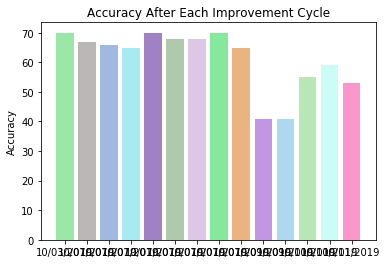

In [42]:
when = plotdata.iloc[:,0]
performance = plotdata.iloc[:,3]

y_pos = np.arange(len(when))
plt.bar(y_pos, performance, align='center', alpha=0.5, color=colors)


plt.xticks(y_pos, when)
plt.ylabel('Accuracy')
plt.title('Accuracy After Each Improvement Cycle')



plt.savefig('AccuracyExamplesOct02.png')
plt.savefig('AccuracyExamplesOct02.pdf')

In [92]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
porter = PorterStemmer()
lancaster=LancasterStemmer()
#proide a word to be stemmed
print("Porter Stemmer")
print(porter.stem("cats"))

class LemmaTokenizer(object):
    def __init__(self):
            self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

#vect = CountVectorizer(tokenizer=LemmaTokenizer())  